# East coast floods


In [49]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "MIROC6"
min_lead = 1
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "file_lists/MIROC6_dcppA-hindcast_files.txt"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_MIROC6-dcppA-hindcast_196011-201811_base-196011-201811.zarr.zip"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s1960-r1i1p1f1/day/pr/gn/v20191217/pr_day_MIROC6_dcppA-hindcast_s1960-r1i1p1f1_gn_19601101-19691231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {'time': 0}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

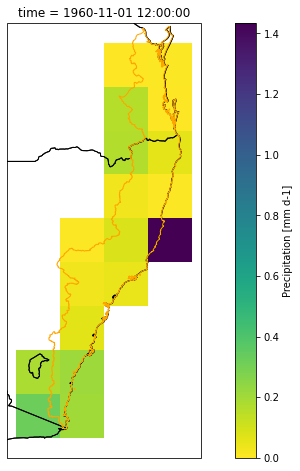

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 10, init_date: 59, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 9
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(59, 10, 11), meta=np.ndarray>
  * init_date   (init_date) object 1960-11-01 00:00:00 ... 2018-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 59), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          Branching from dcppA-assim, but atmospheric initi...
    branch_time_in_child:   0.0
    branch_time_in_parent:  3957.0
    cmor_version:           3.4.0
    ...                     ...
    table_id:               day
    table_info:             Creation Date:(22 July 2019) MD5:b4cefb4b6dbb146f...
    title:                  MIROC6 output prepared for CMIP6
    tracking_id:            hdl:21.14100/95da9468-c246-4aba-a9e3-9be21aa5772f
    variable_id:            pr
    variant_label:          r1i1p1f1

### Independence testing

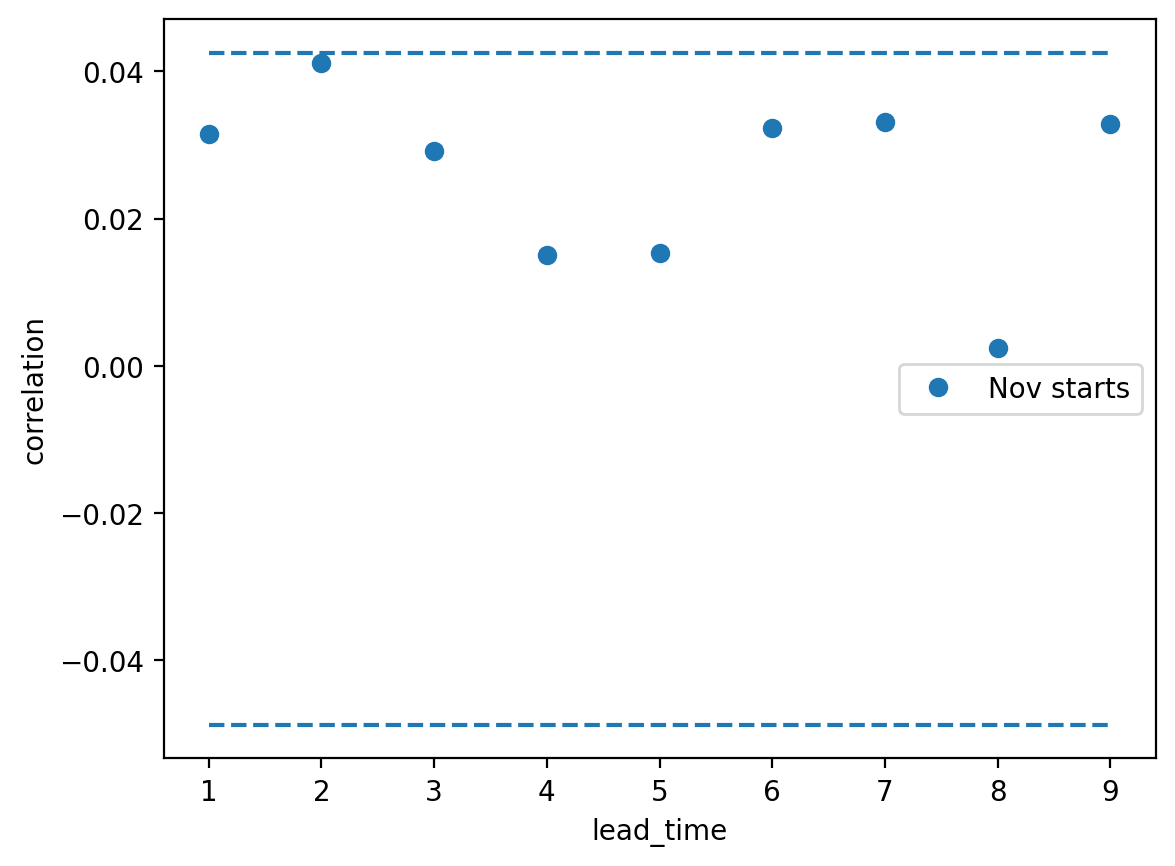

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

1


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

### Bias correction and similarity testing

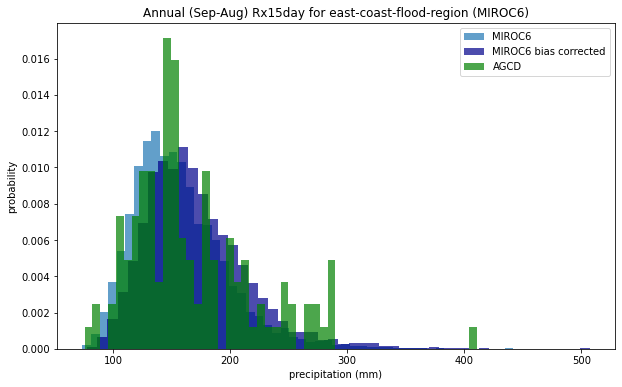

In [20]:
fig = plt.figure(figsize=[10, 6])
model_da.plot.hist(bins=50, density=True, label=model_name, alpha=0.7)
model_bc_ds['pr'].plot.hist(bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7)
agcd_ds['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [21]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [22]:
similarity_raw_ds['ks_pval'].values

array([0.07326378, 0.00940865, 0.04291191, 0.25817025, 0.2713403 ,
       0.06023606, 0.02412306, 0.07810497, 0.0832129 ], dtype=float32)

In [23]:
similarity_raw_ds['ad_pval'].values

array([0.10368264, 0.001     , 0.01768902, 0.24470228, 0.23183908,
       0.05088   , 0.0015494 , 0.02548427, 0.05934113], dtype=float32)

In [24]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)

In [25]:
similarity_bias_ds['ks_pval'].values

array([0.18888335, 0.14299339, 0.10024507, 0.1788872 , 0.2713403 ,
       0.18888335, 0.14299339, 0.12735316, 0.29911944], dtype=float32)

In [26]:
similarity_bias_ds['ad_pval'].values

array([0.21827818, 0.10951988, 0.16529329, 0.25      , 0.25      ,
       0.25      , 0.15801872, 0.17088188, 0.17202067], dtype=float32)

### Exceedance curves

In [27]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [28]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period\n')

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

In [29]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [30]:
model_bc_da_stacked.shape

(5310,)

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_MIROC6.png


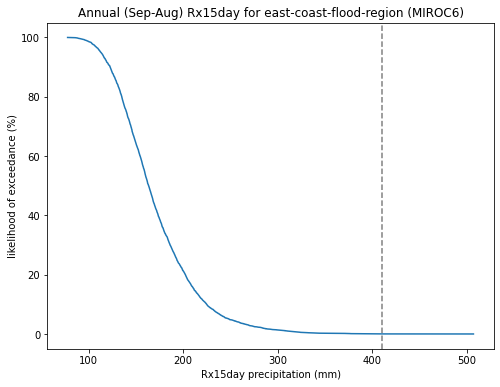

In [31]:
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [32]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2022, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
2 events in 5310 samples
99.96% percentile
2655 year return period


1960-1969
0 events in 450 samples
100.00% percentile
inf year return period



/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


1970-1979


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 900 samples
100.00% percentile
inf year return period

1980-1989
1 events in 900 samples
99.89% percentile
900 year return period

1990-1999


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 900 samples
100.00% percentile
inf year return period

2000-2009
1 events in 900 samples
99.89% percentile
900 year return period

2010-2019


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 900 samples
100.00% percentile
inf year return period

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_MIROC6_by-decade.png


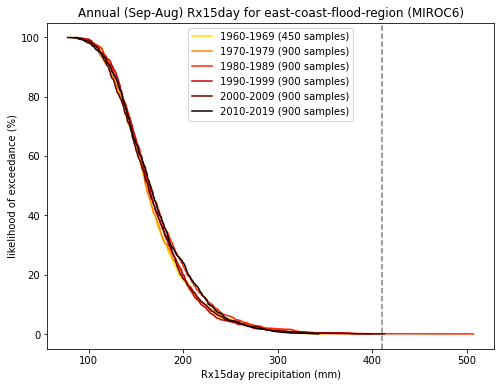

In [33]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

In [34]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [35]:
model_da_stacked.shape

(5310,)

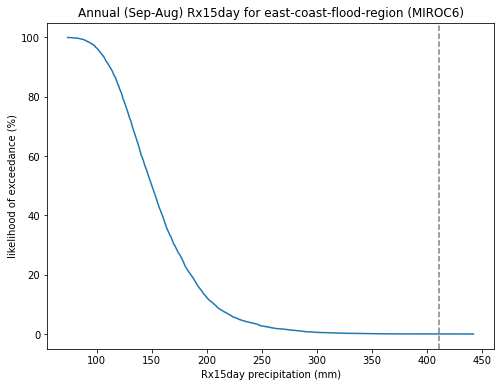

In [36]:
plot_exceedance(model_da_stacked, model_name)

In [37]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
1 events in 5310 samples
99.98% percentile
5310 year return period


### Seasonality

In [38]:
model_df = model_ds['pr'].to_dataframe()
model_df = model_df.dropna()
model_df = model_df.reset_index()
model_df

,init_date,ensemble,lead_time,event_time,time,pr
0,1960-11-01 00:00:00,0,1,1962-03-13,1961-11-01 12:00:00,152.417386
1,1960-11-01 00:00:00,0,2,1962-09-20,1962-11-01 12:00:00,106.547628
2,1960-11-01 00:00:00,0,3,1964-03-10,1963-11-02 12:00:00,115.598386
3,1960-11-01 00:00:00,0,4,1964-11-03,1964-11-01 12:00:00,154.495020
4,1960-11-01 00:00:00,0,5,1966-06-07,1965-11-01 12:00:00,128.177570
...,...,...,...,...,...,...
5305,2018-11-01 00:00:00,9,5,2024-01-29,2023-11-02 12:00:00,152.380569
5306,2018-11-01 00:00:00,9,6,2025-03-22,2024-11-01 12:00:00,205.773246
5307,2018-11-01 00:00:00,9,7,2026-03-26,2025-11-01 12:00:00,216.776507
5308,2018-11-01 00:00:00,9,8,2026-09-01,2026-11-01 12:00:00,118.815602


In [39]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

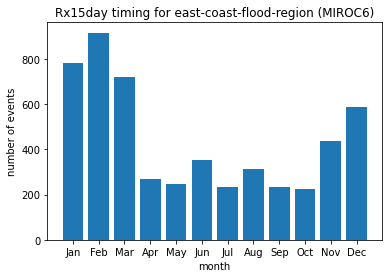

In [40]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [41]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (ensemble: 10, init_date: 59, lead_time: 122)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) <U6 '196011' '196111' '196211' ... '201711' '201811'
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 115 116 117 118 119 120 121
    time       (lead_time, init_date) object dask.array<chunksize=(122, 59), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 122), meta=np.ndarray>
Attributes:
    history:  Mon Jan 30 19:09:42 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [42]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [43]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


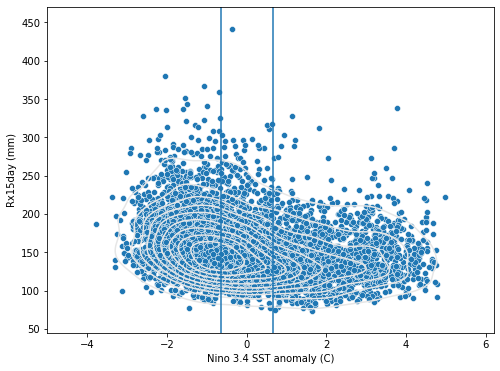

In [44]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [45]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [46]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr,nino34
1648,1978-11-01 00:00:00,3,2,1981-02-27,1980-11-01 12:00:00,441.878570,-0.358295
3929,2003-11-01 00:00:00,6,6,2010-02-19,2009-10-31 12:00:00,379.469096,-2.034729
3020,1993-11-01 00:00:00,5,6,2000-03-09,1999-11-02 12:00:00,367.190542,-1.068043
1736,1979-11-01 00:00:00,2,9,1989-02-12,1988-10-31 12:00:00,359.518069,-0.693754
3042,1993-11-01 00:00:00,8,1,1995-02-12,1994-11-01 12:00:00,351.493236,-1.551006
858,1969-11-01 00:00:00,5,4,1974-02-19,1973-11-01 12:00:00,343.960658,-1.501932
2366,1986-11-01 00:00:00,2,9,1996-02-01,1995-11-02 12:00:00,341.199184,-0.983955
3219,1995-11-01 00:00:00,7,7,2003-01-30,2002-10-31 12:00:00,338.257125,3.760788
5285,2018-11-01 00:00:00,7,3,2022-02-20,2021-11-01 12:00:00,337.571486,-1.598518
1090,1972-11-01 00:00:00,1,2,1975-02-12,1974-11-01 12:00:00,336.359287,-2.276064


In [47]:
model_bc_df = model_bc_ds['pr'].to_dataframe()
model_bc_df = model_bc_df.dropna()
model_bc_df = model_bc_df.reset_index()
ranked_bc_events = model_bc_df.sort_values(by=['pr'], ascending=False)
ranked_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
1648,1978-11-01 00:00:00,3,2,1981-02-27,1980-11-01 12:00:00,507.056680
3929,2003-11-01 00:00:00,6,6,2010-02-19,2009-10-31 12:00:00,412.872142
3020,1993-11-01 00:00:00,5,6,2000-03-09,1999-11-02 12:00:00,399.512758
3219,1995-11-01 00:00:00,7,7,2003-01-30,2002-10-31 12:00:00,388.274150
1090,1972-11-01 00:00:00,1,2,1975-02-12,1974-11-01 12:00:00,385.973058
1736,1979-11-01 00:00:00,2,9,1989-02-12,1988-10-31 12:00:00,383.323074
3042,1993-11-01 00:00:00,8,1,1995-02-12,1994-11-01 12:00:00,377.100975
2886,1992-11-01 00:00:00,0,7,2000-02-02,1999-11-02 12:00:00,376.914728
5285,2018-11-01 00:00:00,7,3,2022-02-20,2021-11-01 12:00:00,376.640430
2395,1986-11-01 00:00:00,6,2,1988-12-25,1988-11-01 12:00:00,376.146173


1978 (1981-02-27), ensemble: r4, 441.87857042739955mm


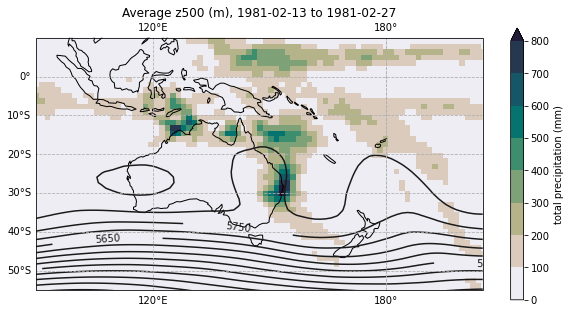

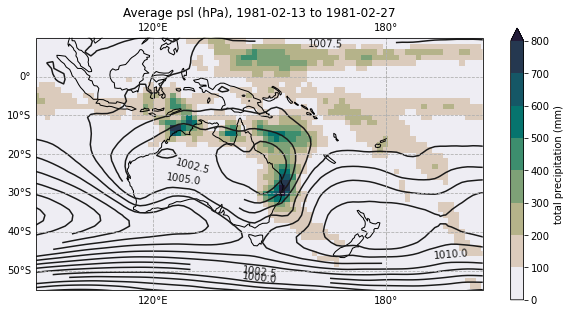

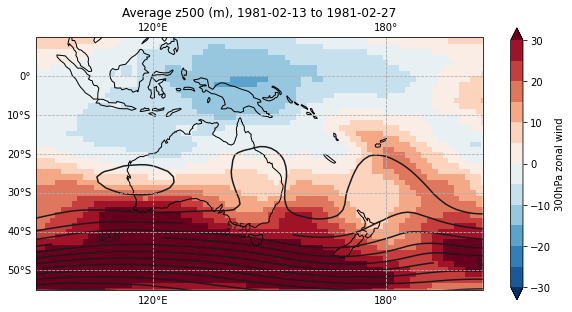

2003 (2010-02-19), ensemble: r7, 379.4690964942481mm


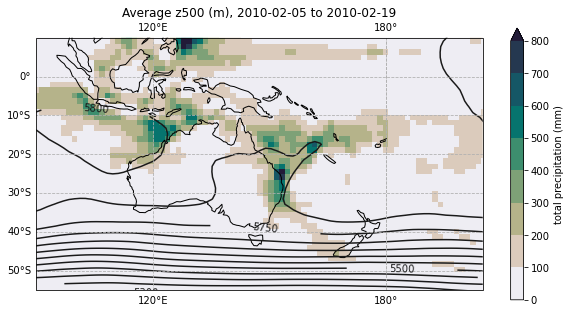

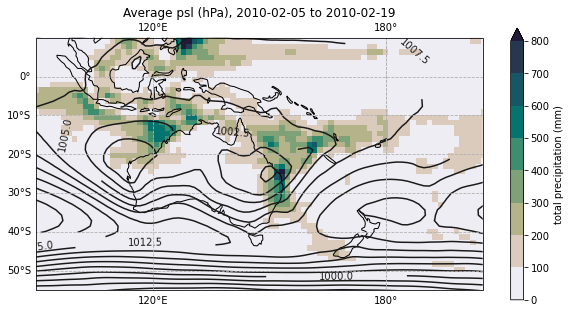

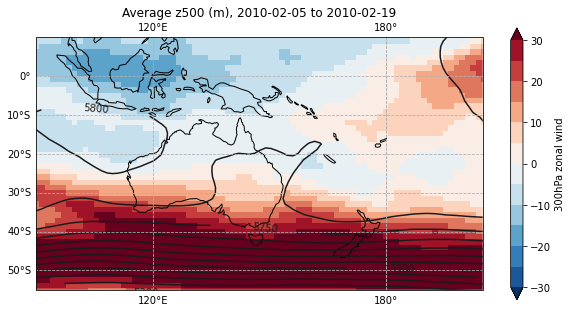

1993 (2000-03-09), ensemble: r6, 367.1905418908925mm


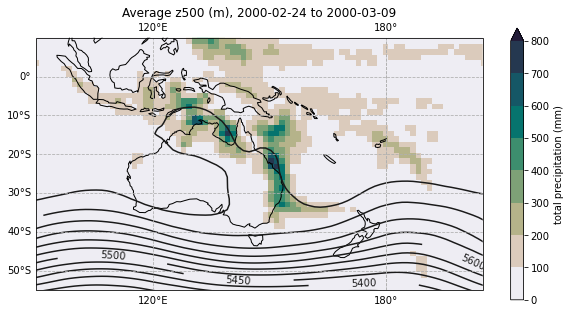

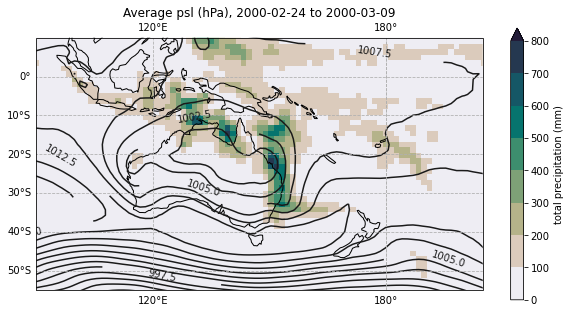

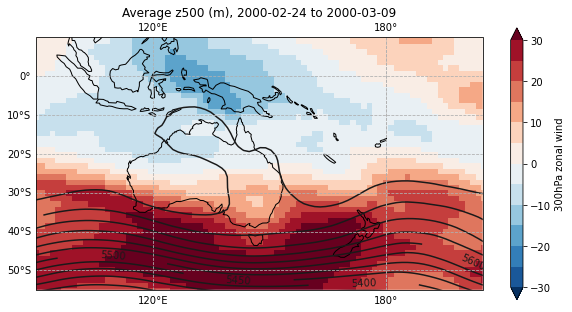

1979 (1989-02-12), ensemble: r3, 359.5180694165594mm


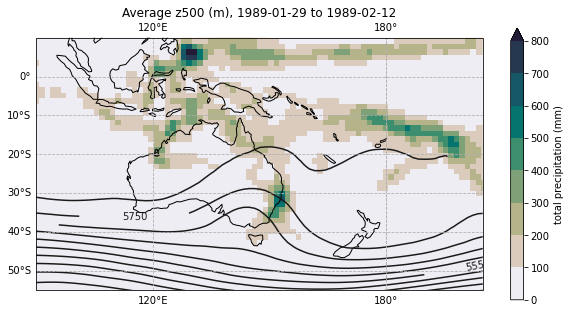

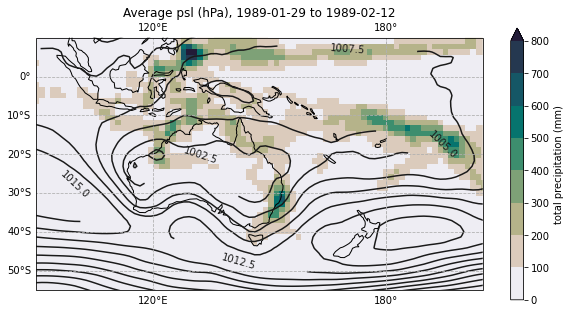

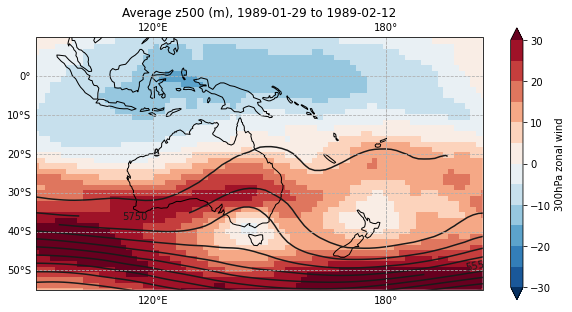

In [68]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/pr/gn/v20191217/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/psl/gn/v20191217/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/gn/v20191217/*.nc')
    zg_files.sort()
    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/gn/v20191217/*.nc')
    ua_files.sort()
    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)
    
    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
    plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
    plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)